# AutoML for Images - Mask Object Detection - Downloading images and labels

In [18]:
import json
import os
import urllib
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from zipfile import ZipFile
from PIL import Image as pil_image

## Downloading images and labels

In [2]:
print("1. Downloading zip file...")
download_url = "https://github.com/retkowsky/CustomVision_Datasets/raw/master/covid19images.zip"
zip_file = "covid19images.zip"
urllib.request.urlretrieve(download_url, filename=zip_file)
print("Done.")

print("\n2. Unzipping file...")
with ZipFile(zip_file, "r") as zip:
    print("extracting files...")
    zip.extractall()
print("Done.")

print("\n3. Removing zip file...")
os.remove(zip_file)
print("Done.")

1. Downloading zip file...
Done.

2. Unzipping file...
extracting files...
Done.

3. Removing zip file...
Done.


## Viewing images

In [3]:
train_dir = "train"
valid_dir = "valid"

nbfiles_train = sum(len(files) for _, _, files in os.walk(train_dir))
print("Number of files in directory", train_dir, "=", nbfiles_train)

nbfiles_val = sum(len(files) for _, _, files in os.walk(valid_dir))
print("Number of files in directory", valid_dir, "=", nbfiles_val)

Number of files in directory train = 106
Number of files in directory valid = 30


In [4]:
training_images_list = os.listdir(train_dir)

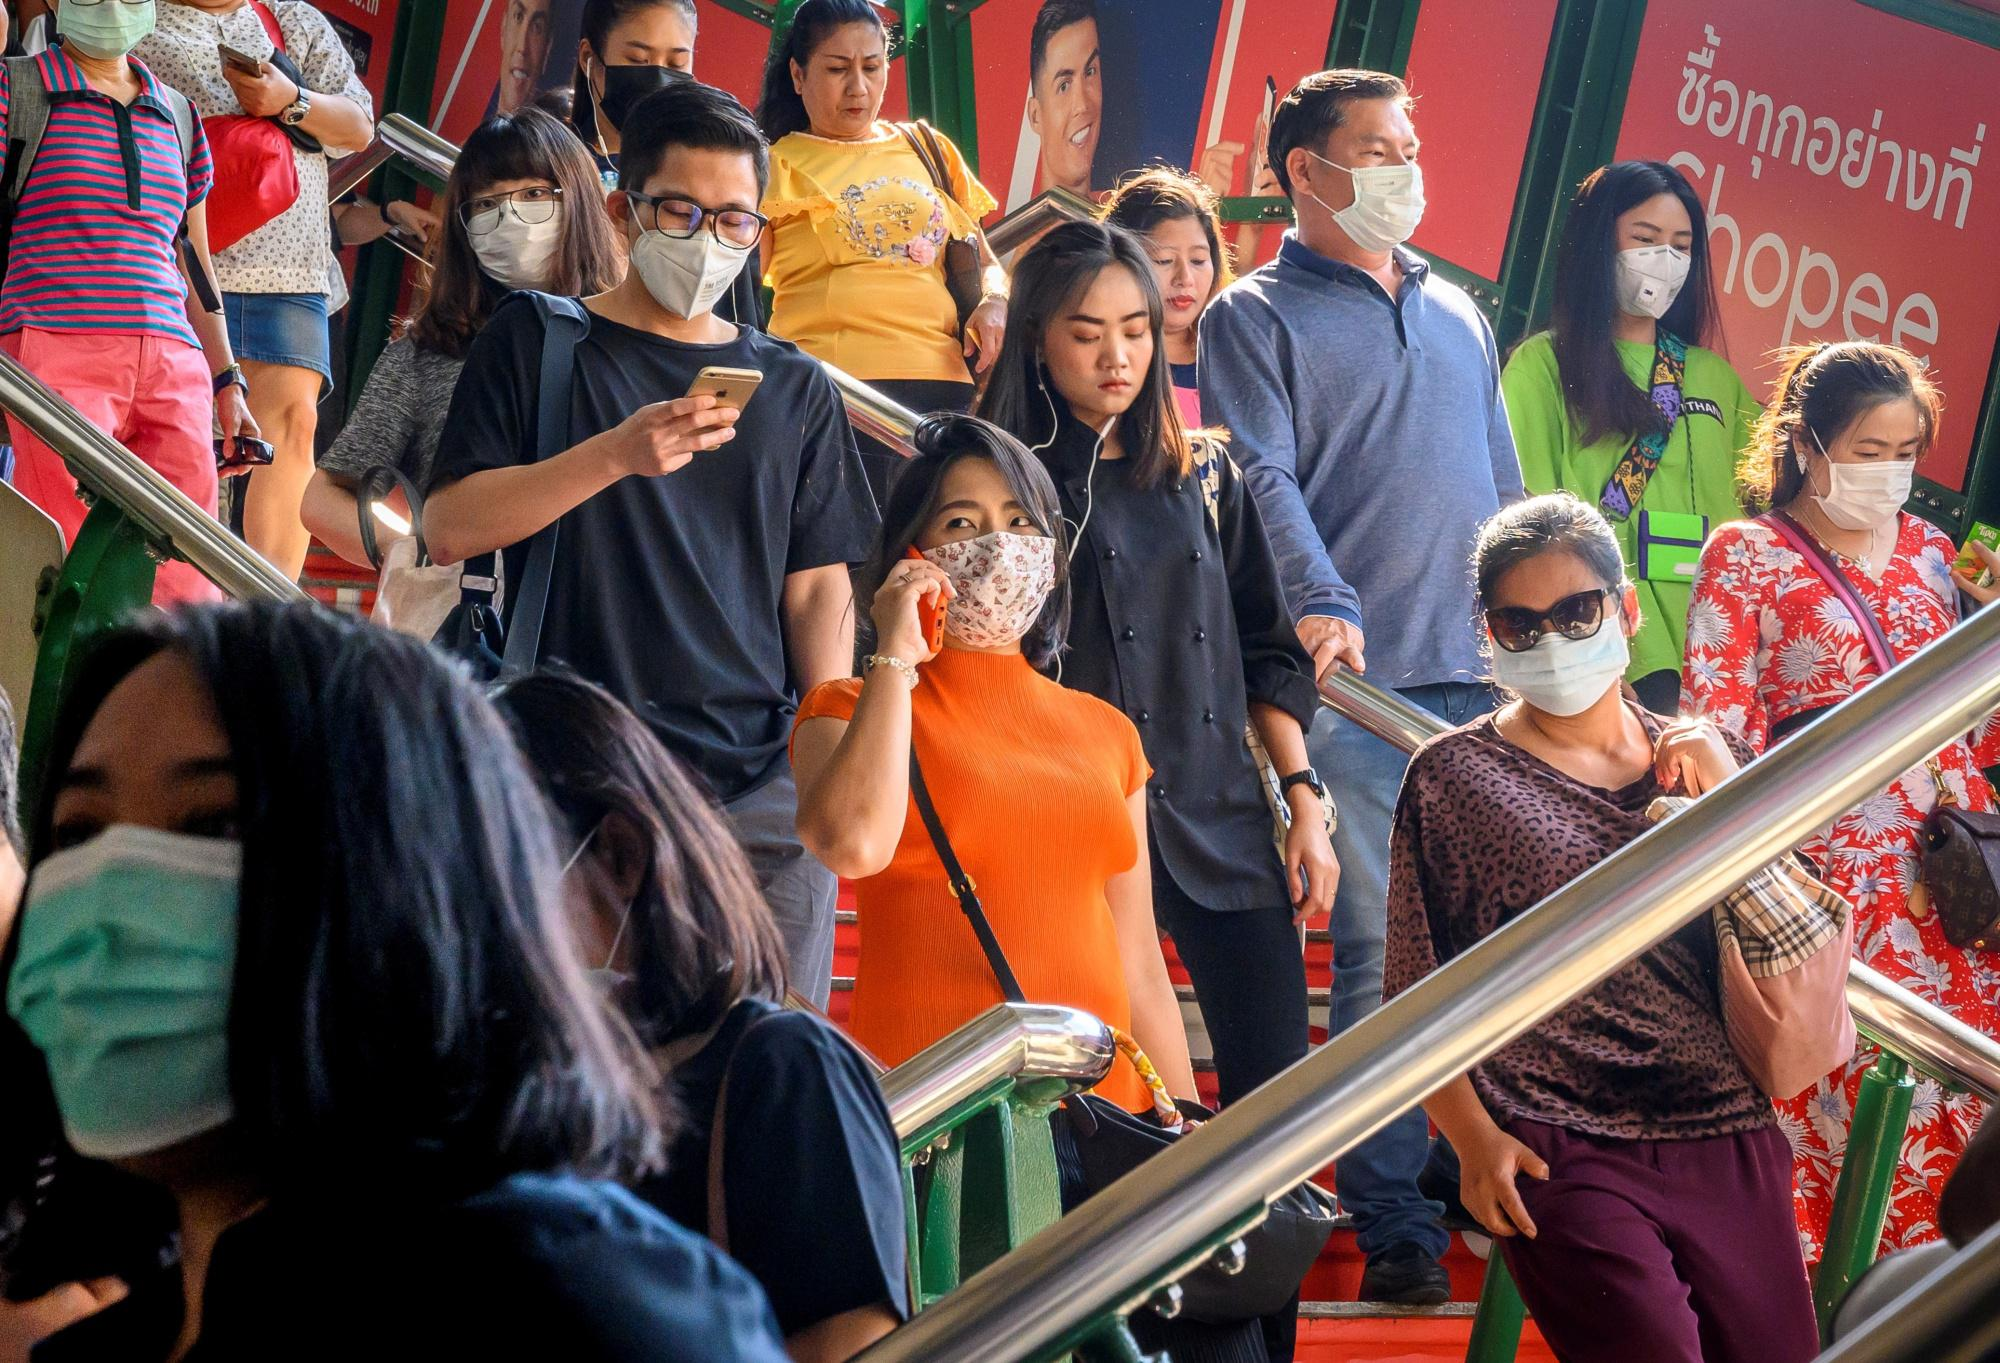

In [5]:
from IPython.display import Image

sample_image = os.path.join(train_dir, training_images_list[0])
Image(filename=sample_image, width=640, height=480)

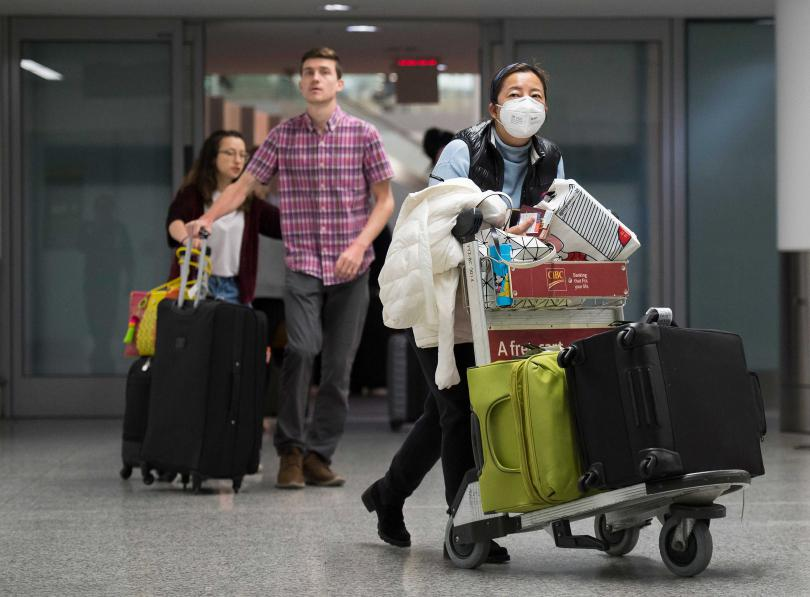

In [6]:
sample_image = os.path.join(train_dir, training_images_list[10])
Image(filename=sample_image, width=640, height=480)

## Convert annotation file from COCO to JSONL

These images are already labelled so there is no need to use Azure ML Data Labelling. But we need to transform the initial COCO file format (labels) to the Azure ML required JSONL file for the labels. Next we will run a python script that will do the job.

### For the training images

In [7]:
# Generate annotation jsonl file from coco file
!python coco2jsonl.py \
--input_coco_file_path "./train/annotationscoco.json" \
--output_dir "./train" --output_file_name "covidmask_train.jsonl" \
--task_type "ObjectDetection" \
--base_url "AmlDatastore://workspaceblobstore/train/"

Converting for ObjectDetection
Conversion completed. Converted 105 lines.


In [8]:
!ls train/covidmask_train.jsonl -lh

-rwxrwxrwx 1 root root 107K Feb  1 11:00 train/covidmask_train.jsonl


### For the validation images

In [9]:
# Generate annotation jsonl file from coco file
!python coco2jsonl.py \
--input_coco_file_path "./valid/annotationscoco.json" \
--output_dir "./valid" --output_file_name "covidmask_valid.jsonl" \
--task_type "ObjectDetection" \
--base_url "AmlDatastore://workspaceblobstore/valid/"

Converting for ObjectDetection
Conversion completed. Converted 29 lines.


In [10]:
!ls valid/covidmask_valid.jsonl -lh

-rwxrwxrwx 1 root root 26K Feb  1 11:00 valid/covidmask_valid.jsonl


So we have our images and labels. We can display some training images with the labels

## Visualize bounding boxes

In [11]:
def plot_ground_truth_boxes(image_file, ground_truth_boxes):
    """
    Printing labels
    """
    
    nb_masks = nb_nomasks = 0
    plt.figure()
    img_np = mpimg.imread(image_file)
    img = pil_image.fromarray(img_np.astype("uint8"), "RGB")
    img_w, img_h = img.size

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.imshow(img_np)
    ax.axis("off")

    for gt in ground_truth_boxes:
        label = gt["label"]

        xmin, ymin, xmax, ymax =  gt["topX"], gt["topY"], gt["bottomX"], gt["bottomY"]
        topleft_x, topleft_y = img_w * xmin, img_h * ymin
        width, height = img_w * (xmax - xmin), img_h * (ymax - ymin)

        colorlime = 'lime'
        colorred = 'red'
        
        if label == 'mask':
            rect = patches.Rectangle((topleft_x, topleft_y), width, height,
                                 linewidth = 3, edgecolor = colorlime, facecolor = "none")
            ax.add_patch(rect)
            # Display label
            ax.text(topleft_x, topleft_y - 10, label, color = colorlime, fontsize = 12)
            nb_masks += 1
            
        if label != 'mask':
            rect = patches.Rectangle((topleft_x, topleft_y), width, height,
                                 linewidth = 3, edgecolor=colorred, facecolor = "none")
            ax.add_patch(rect)
            
            ax.text(topleft_x, topleft_y - 10, label, color = colorred, fontsize = 12)
            nb_nomasks += 1
    
    print("Image with labels:", image_file)
    print("\nTotal of labelled objects =", nb_masks + nb_nomasks)
    print("- Number of objects labelled 'mask' =", nb_masks)
    print("- Number of objects labelled 'no-mask' =", nb_nomasks)
    
    plt.show()

In [12]:
def plot_ground_truth_boxes_jsonl(image_file, jsonl_file):
    """
    Viewing image & labels
    """
    image_base_name = os.path.basename(image_file)
    ground_truth_data_found = False
    
    with open(jsonl_file) as fp:
        for line in fp.readlines():
            line_json = json.loads(line)
            filename = line_json["image_url"]
            if image_base_name in filename:
                ground_truth_data_found = True
                plot_ground_truth_boxes(image_file, line_json["label"])
                break
    
    if not ground_truth_data_found:
        print("Unable to find ground truth information for image: {}".format(image_file))

Image with labels: train/-1x-1_jpg.rf.69d9b61e3cdb8a9047dad25099fcc8ef.jpg

Total of labelled objects = 13
- Number of objects labelled 'mask' = 9
- Number of objects labelled 'no-mask' = 4


<Figure size 640x480 with 0 Axes>

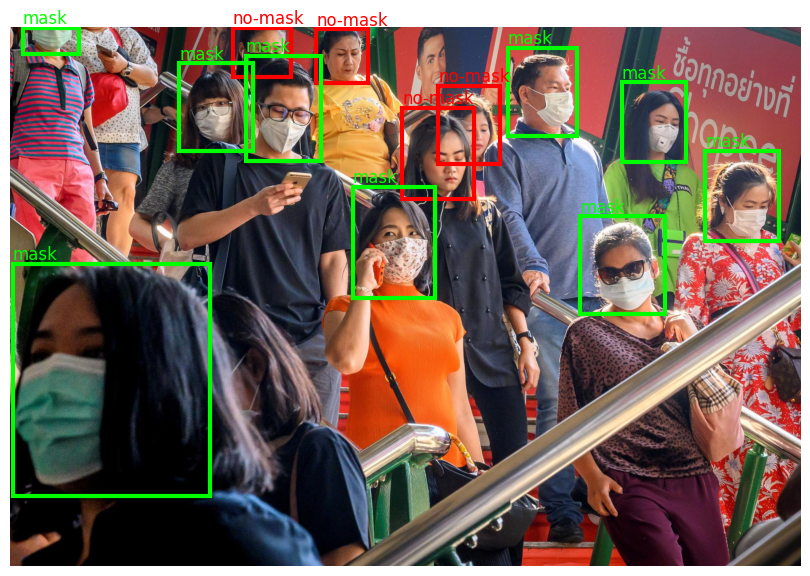

In [19]:
sample_image = os.path.join(train_dir, training_images_list[0])
jsonl_file_location = os.path.join(train_dir, "covidmask_train.jsonl")

plot_ground_truth_boxes_jsonl(sample_image, jsonl_file_location)

Image with labels: train/0200b38c89b16c37c5de8e247bb00c2f_jpg.rf.4868c78878c91c2c7cc7062e90de7658.jpg

Total of labelled objects = 3
- Number of objects labelled 'mask' = 1
- Number of objects labelled 'no-mask' = 2


<Figure size 640x480 with 0 Axes>

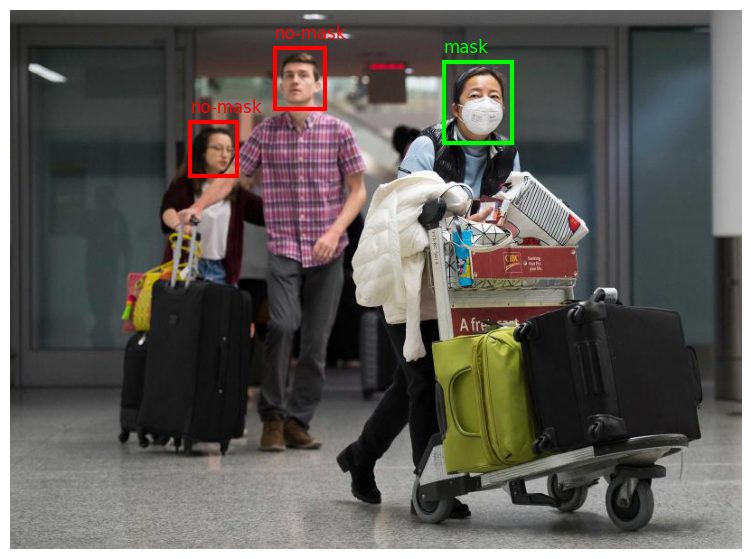

In [20]:
sample_image = os.path.join(train_dir, training_images_list[10])
jsonl_file_location = os.path.join(train_dir, "covidmask_train.jsonl")

plot_ground_truth_boxes_jsonl(sample_image, jsonl_file_location)

Image with labels: train/skynews-coronavirus-london-fashion-week_4920359_jpg.rf.cc22ab2e0f2d8f3472a7ddcfa6177fb7.jpg

Total of labelled objects = 3
- Number of objects labelled 'mask' = 3
- Number of objects labelled 'no-mask' = 0


<Figure size 640x480 with 0 Axes>

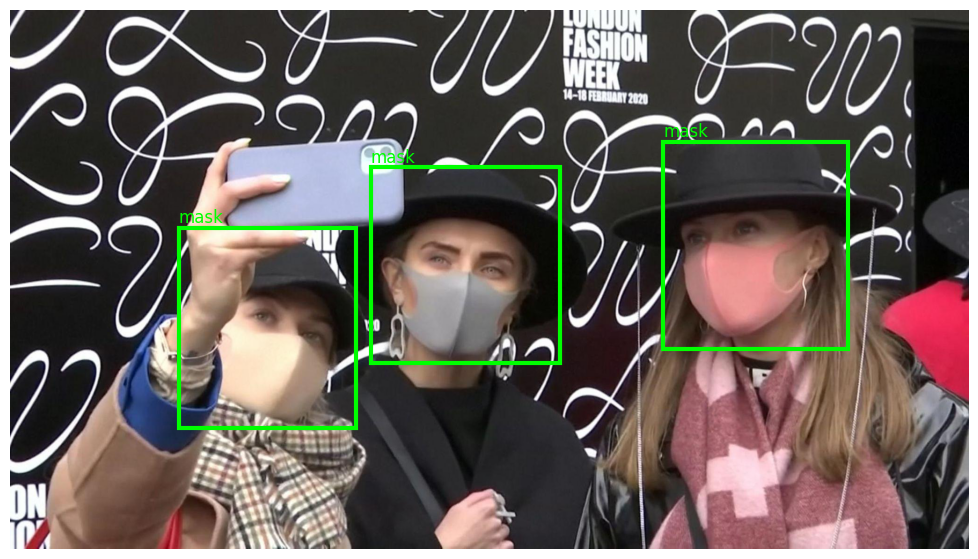

In [21]:
sample_image = os.path.join(train_dir, training_images_list[80])
jsonl_file_location = os.path.join(train_dir, "covidmask_train.jsonl")

plot_ground_truth_boxes_jsonl(sample_image, jsonl_file_location)

Image with labels: train/US-expands-coronavirus-screenings-United-suspends-some-flights-to-China_jpg.rf.7684e0ecdea4004bc109f5482badee55.jpg

Total of labelled objects = 2
- Number of objects labelled 'mask' = 1
- Number of objects labelled 'no-mask' = 1


<Figure size 640x480 with 0 Axes>

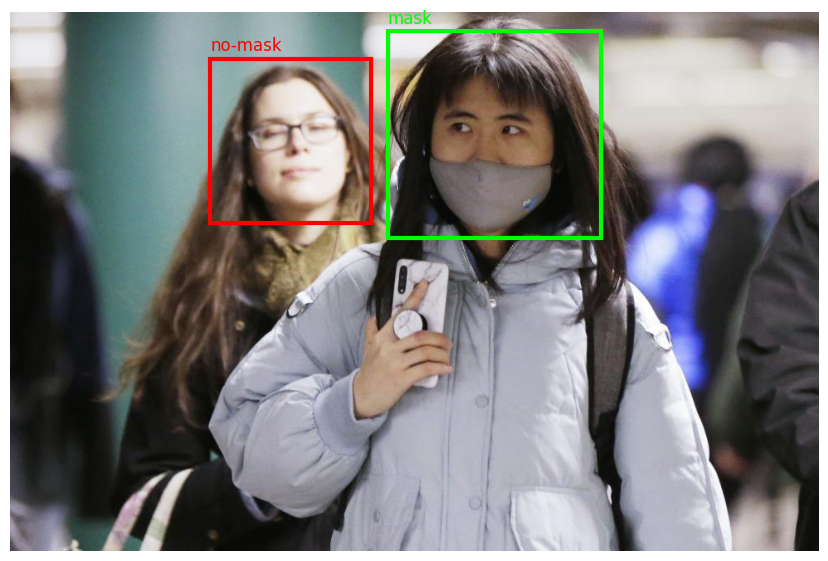

In [22]:
sample_image = os.path.join(train_dir, training_images_list[100])
jsonl_file_location = os.path.join(train_dir, "covidmask_train.jsonl")

plot_ground_truth_boxes_jsonl(sample_image, jsonl_file_location)

## We will use the 2 jsonl labels files in the next notebook

In [23]:
ls train/covidmask_train.jsonl -lh

-rwxrwxrwx 1 root root 107K Feb  1 11:00 train/covidmask_train.jsonl*


In [24]:
ls valid/covidmask_valid.jsonl -lh

-rwxrwxrwx 1 root root 26K Feb  1 11:00 valid/covidmask_valid.jsonl*


In [25]:
with open('train/covidmask_train.jsonl', 'r') as f:
    print(f.read())

{"image_url":"AmlDatastore://workspaceblobstore/train/11893820-3x2-xlarge_jpg.rf.1529b09bfee7d069f677ff513f6249eb.jpg","image_details":{"format":"jpg","width":862,"height":575},"label":[{"label":"mask","topX":0.4466357308584687,"topY":0.0,"bottomX":0.5498839907192575,"bottomY":0.1634782608695652,"isCrowd":0},{"label":"no-mask","topX":0.580046403712297,"topY":0.4469565217391304,"bottomX":0.7076566125290024,"bottomY":0.7356521739130435,"isCrowd":0},{"label":"mask","topX":0.10904872389791183,"topY":0.006956521739130435,"bottomX":0.18909512761020883,"bottomY":0.13043478260869565,"isCrowd":0},{"label":"mask","topX":0.8723897911832946,"topY":0.17565217391304347,"bottomX":0.9779582366589327,"bottomY":0.3652173913043478,"isCrowd":0},{"label":"no-mask","topX":0.6995359628770301,"topY":0.1443478260869565,"bottomX":0.796983758700696,"bottomY":0.31478260869565217,"isCrowd":0},{"label":"no-mask","topX":0.9454756380510441,"topY":0.0052173913043478265,"bottomX":0.9976798143851509,"bottomY":0.13565217

In [26]:
with open('valid/covidmask_valid.jsonl', 'r') as f:
    print(f.read())

{"image_url":"AmlDatastore://workspaceblobstore/valid/1125506397_15801322206581n_jpg.rf.3c089d43976a3dd3b0dfab58bdcac999.jpg","image_details":{"format":"jpg","width":899,"height":642},"label":[{"label":"mask","topX":0.746384872080089,"topY":0.16510903426791276,"bottomX":0.9221357063403782,"bottomY":0.45794392523364486,"isCrowd":0},{"label":"mask","topX":0.4593993325917686,"topY":0.1308411214953271,"bottomX":0.5917686318131257,"bottomY":0.3629283489096573,"isCrowd":0},{"label":"mask","topX":0.22803114571746386,"topY":0.11526479750778816,"bottomX":0.41268075639599555,"bottomY":0.3894080996884735,"isCrowd":0}]}
{"image_url":"AmlDatastore://workspaceblobstore/valid/sdgdsgsg_jpg.rf.2296809055f00546a3bb756a73bb4472.jpg","image_details":{"format":"jpg","width":768,"height":768},"label":[{"label":"mask","topX":0.0026041666666666665,"topY":0.20442708333333334,"bottomX":0.18489583333333334,"bottomY":0.5416666666666666,"isCrowd":0},{"label":"mask","topX":0.7903645833333334,"topY":0.35286458333333